In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
# R-like interface, alternatively you can import statsmodels as import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import theano
from sklearn.model_selection import train_test_split
import arviz as az


from scipy.special import logsumexp

%config InlineBackend.figure_formats = ['retina']
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

##### 6E1
1. Information criterion must be continuous. 
2. Information criterion should increase as the number of possibilities increase. This means as the possible outcome increases
    it becomes harder to 'hit the target'
3. Information criterion should be additive. For example if 2 possible events have a score of 0.3, and another 3 events have a
    score of 0.45, the total score of 5 events should be 0.3 + 0.45 = 0.75
    

In [2]:
# 6E2
# See page 178
p = (0.3, 0.7)
-sum(p * np.log(p))

0.6108643020548935

In [3]:
# 6E3
# See page 178
p = (0.2, 0.25,0.25,0.3)
-sum(p * np.log(p))

1.3762266043445461

In [5]:
# 6E4
# See top of page 179 for L'Hopital's rule
p = (1/3, 1/3,1/3)
-sum(p * np.log(p))

1.0986122886681096

##### 6M1
(skip first part of question) WAIC is the most general of the three.

##### 6M2
Model Selection is when we pick the best model with the lowest WAIC score, whereas model averaging is prediction averaging which incorporates what we know about the models' relative accuracy. Model selection disregards the differences between models' WAIC scores, which tells us how confident we should be about models. 

##### 6M3
Model with fewer observations will always have lower WAIC score, because the model is asked to predict less. 

##### 6M4
Page, 191. "Effective" number of parameters measures how flexible model is. As priors beomces more restrictive, the model becomes less flexible and thus reducing the number of effective parameters. 

##### 6M5
Priors reduce overfitting because it makes the model skeptical of values outside of the defined prior. If the prior does a good job defining the possible boundries, then the models will be skeptical from outliers and refrain from assiging too much probability to the outliers.

##### 6M6
Overly restrictive priors prevents the model from learning from data, because it considers large percentage of the data as 'impossible'.


In [3]:
# 6H1
df=pd.read_csv('../Data/Howell1.csv', sep=';', header=0)
train_howell, test_howell = train_test_split(df,test_size=0.5,random_state=12345)
test_howell.head()

,height,weight,age,male
431,132.0800,28.292801,11.0,1
89,136.5250,36.287360,79.0,0
426,151.9428,43.714929,21.0,1
503,123.8250,21.545620,11.0,1
533,152.4000,40.823280,49.0,0


In [4]:
train_howell['age.std'] = (train_howell['age'] - train_howell['age'].mean()) / \
                            train_howell['age'].std()

train_howell['height.std'] = (train_howell['height'] - train_howell['height'].mean()) / \
                            train_howell['height'].std()
    
test_howell['age.std'] = (test_howell['age'] - test_howell['age'].mean()) / \
                            test_howell['age'].std()

test_howell['height.std'] = (test_howell['height'] - test_howell['height'].mean()) / \
                            test_howell['height'].std()


/Users/yangyu/Desktop/env/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/yangyu/Desktop/env/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yangyu/Desktop/env/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [5]:
with pm.Model() as m_6h1_1:
    alpha = pm.Normal('a',140,30)
    beta = pm.Normal('b',0,10)
    mu = pm.Deterministic('mu',alpha + beta*train_howell['age'])
    sigma = pm.HalfCauchy('sigma', beta=10)
    height = pm.Normal('height',mu,sigma,observed=train_howell['height'])
    trace_m_6h1_1 = pm.sample(1000, tune=1000)
    

with pm.Model() as m_6h1_2:
    alpha = pm.Normal('a',0,10)
    beta_1 = pm.Normal('b_1',0,10)
    beta_2 = pm.Normal('b_2',0,10)
    mu = pm.Deterministic('mu',alpha \
                          + beta_1*train_howell['age.std']\
                          + beta_2*train_howell['age.std']**2)
    sigma = pm.HalfCauchy('sigma', beta=15)
    height = pm.Normal('height',mu,sigma,observed=train_howell['height.std'])
    trace_m_6h1_2 = pm.sample(1000, tune=1000)
    
with pm.Model() as m_6h1_3:
    alpha = pm.Normal('a',0,10)
    beta_1 = pm.Normal('b_1',0,10)
    beta_2 = pm.Normal('b_2',0,10)
    beta_3 = pm.Normal('b_3',0,10)
    mu = pm.Deterministic('mu',alpha  \
                          + beta_1*train_howell['age.std'] \
                          + beta_2*train_howell['age.std']**2\
                          + beta_3*train_howell['age.std']**3)
    sigma = pm.HalfCauchy('sigma', beta=15)
    height = pm.Normal('height',mu,sigma,observed=train_howell['height.std'])
    trace_m_6h1_3 = pm.sample(1000, tune=1000)
    
with pm.Model() as m_6h1_4:
    alpha = pm.Normal('a',0,10)
    beta_1 = pm.Normal('b_1',0,10)
    beta_2 = pm.Normal('b_2',0,10)
    beta_3 = pm.Normal('b_3',0,10)
    beta_4 = pm.Normal('b_4',0,10)
    mu = pm.Deterministic('mu',alpha  \
                          + beta_1*train_howell['age.std'] \
                          + beta_2*train_howell['age.std']**2\
                          + beta_3*train_howell['age.std']**3\
                          + beta_4*train_howell['age.std']**4\
                         )
    sigma = pm.HalfCauchy('sigma', beta=15)
    height = pm.Normal('height',mu,sigma,observed=train_howell['height.std'])
    trace_m_6h1_4 = pm.sample(1000, tune=1000)

with pm.Model() as m_6h1_5:
    alpha = pm.Normal('a',0,10)
    beta_1 = pm.Normal('b_1',0,10)
    beta_2 = pm.Normal('b_2',0,10)
    beta_3 = pm.Normal('b_3',0,10)
    beta_4 = pm.Normal('b_4',0,10)
    beta_5 = pm.Normal('b_5',0,10)
    mu = pm.Deterministic('mu',alpha \
                          + beta_1*train_howell['age.std'] \
                          + beta_2*train_howell['age.std']**2\
                          + beta_3*train_howell['age.std']**3\
                          + beta_4*train_howell['age.std']**4\
                          + beta_5*train_howell['age.std']**5\
                         )
    sigma = pm.HalfCauchy('sigma', beta=15)
    height = pm.Normal('height',mu,sigma,observed=train_howell['height.std'])
    trace_m_6h1_5 = pm.sample(1000, tune=1000)
    
with pm.Model() as m_6h1_6:
    alpha = pm.Normal('a',0,10)
    beta_1 = pm.Normal('b_1',0,10)
    beta_2 = pm.Normal('b_2',0,10)
    beta_3 = pm.Normal('b_3',0,10)
    beta_4 = pm.Normal('b_4',0,10)
    beta_5 = pm.Normal('b_5',0,10)
    beta_6 = pm.Normal('b_6',0,10)
    mu = pm.Deterministic('mu',alpha \
                          + beta_1*train_howell['age.std'] \
                          + beta_2*train_howell['age.std']**2\
                          + beta_3*train_howell['age.std']**3\
                          + beta_4*train_howell['age.std']**4\
                          + beta_5*train_howell['age.std']**5\
                          + beta_6*train_howell['age.std']**6\
                         )
    sigma = pm.HalfCauchy('sigma', beta=15)
    height = pm.Normal('height',mu,sigma,observed=train_howell['height.std'])
    trace_m_6h1_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1254.13draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_2, b_1, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1317.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_3, b_2, b_1, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 825.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_4, b_3, b_2, b_1, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 425.96draws/s]
The acceptance probability does not match the target. It is 0.881656595814, but should be close to 0.8. Tr

In [11]:
compare_df = az.compare(
    {
        'm_6h1_1':trace_m_6h1_1,
        'm_6h1_2':trace_m_6h1_2,
        'm_6h1_3':trace_m_6h1_3,
        'm_6h1_4':trace_m_6h1_4,
        'm_6h1_5':trace_m_6h1_5,
        'm_6h1_6':trace_m_6h1_6,
    }
    ,method='pseudo-BMA'
#     [trace_m_6h1_1, trace_m_6h1_2, trace_m_6h1_3, trace_m_6h1_4, trace_m_6h1_5, trace_m_6h1_6],
#     [m_6h1_1, m_6h1_2, m_6h1_3, m_6h1_4, m_6h1_5, m_6h1_6], 
)

/Users/yangyu/Desktop/env/jupyter/lib/python3.6/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/Users/yangyu/Desktop/env/jupyter/lib/python3.6/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/Users/yangyu/Desktop/env/jupyter/lib/python3.6/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/Users/yangyu/Desktop/env/jupyt

In [17]:
compare_df

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_6h1_4,149.374,5.54005,0,0.440114,22.2774,0,1,deviance
m_6h1_5,150.259,6.79429,0.885328,0.282695,22.7991,2.68098,1,deviance
m_6h1_6,150.299,7.3548,0.925389,0.277089,22.4212,3.18464,1,deviance
m_6h1_3,166.122,4.93848,16.7477,0.00010159,21.7531,8.45406,1,deviance
m_6h1_2,369.632,6.52807,220.258,6.53499e-49,25.3278,28.1509,1,deviance
m_6h1_1,2393.63,3.63846,2244.26,0,23.3501,29.5644,0,deviance


In [41]:
trace_m_6h1_1['mu'].mean(0)
train_howell['age']

45     17.0
8      19.0
320    33.0
329    27.0
375    12.0
296    56.0
388    41.0
53     13.0
449     6.0
341    49.0
464    30.0
474    10.0
13     20.0
271    28.0
479    24.2
141    62.0
21     39.0
209    62.0
149    33.0
396    21.0
385    38.0
42     52.0
359     2.0
368     3.0
377     1.0
222    82.0
299    34.0
365    55.0
510    39.0
525    15.0
       ... 
124    35.0
387    50.0
36     27.0
353     6.0
287    49.0
439     5.0
29     16.0
23     13.0
231    11.0
43     42.0
263     5.0
166    24.0
81     12.0
77      0.6
267    41.0
208    29.0
374    38.0
91     54.0
105    38.0
315    42.0
369     1.0
118    51.0
357    21.0
382    45.0
425     2.0
420    11.0
129    27.0
285    75.9
485    38.0
482    19.0
Name: age, Length: 272, dtype: float64

/Users/yangyu/Desktop/env/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  if sys.path[0] == '':
100%|██████████| 200/200 [00:00<00:00, 1780.33it/s]
/Users/yangyu/Desktop/env/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
100%|██████████| 200/200 [00:00<00:00, 1265.92it/s]


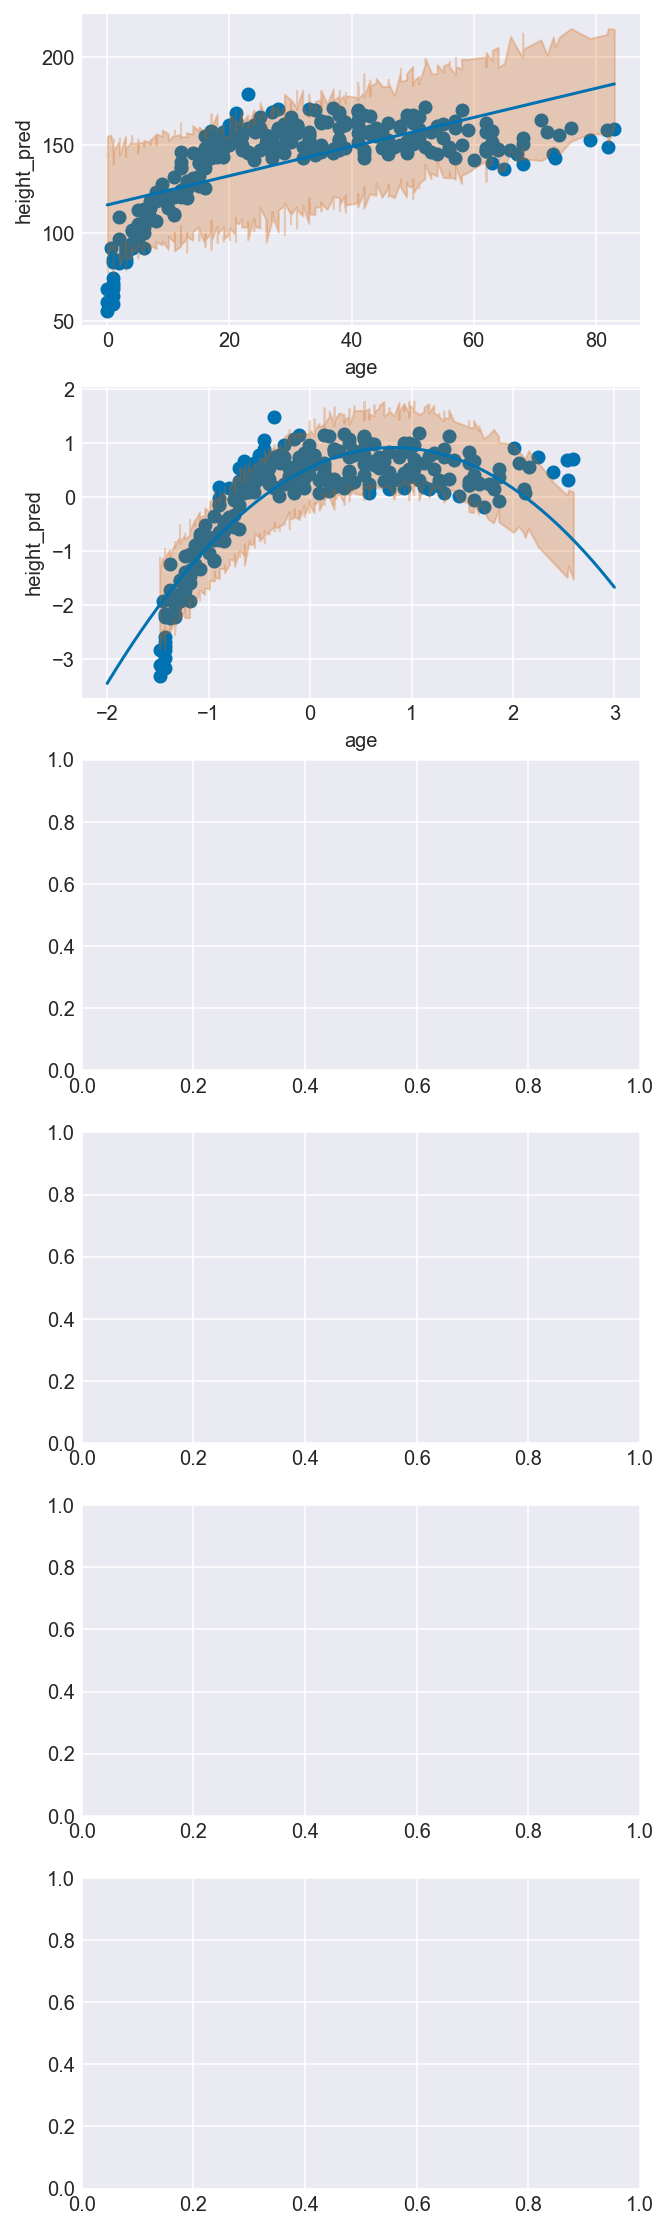

In [85]:
f, axarr = plt.subplots(6, 1, figsize=(5,20))

axarr[0].set_ylabel('height_pred')
axarr[0].set_xlabel('age')
axarr[0].scatter(train_howell['age'], train_howell['height'])
axarr[0].plot(
    np.linspace(train_howell['age'].min(),train_howell['age'].max(),1000),
    trace_m_6h1_1['a'].mean() \
    + trace_m_6h1_1['b'].mean() * np.linspace(train_howell['age'].min(),train_howell['age'].max(),1000)
)

pred = pm.sample_ppc(trace_m_6h1_1, 200, m_6h1_1)
pred_hpd = pm.hpd(pred['height'],alpha=0.11)

idx = np.argsort(train_howell['age'].values)
x_ord = train_howell['age'].values[idx]
pred_hpd = pred_hpd[idx]

axarr[0].fill_between(x_ord, pred_hpd[:,0], pred_hpd[:,1], color='C2', alpha=0.25)

axarr[1].set_ylabel('height_pred')
axarr[1].set_xlabel('age')
axarr[1].scatter(train_howell['age.std'], train_howell['height.std'])
axarr[1].plot(
    np.linspace(-2,3,1000),
    (trace_m_6h1_2['a'].mean() + \
    trace_m_6h1_2['b_1'].mean() * np.linspace(-2,3,1000) + \
    trace_m_6h1_2['b_2'].mean() * np.linspace(-2,3,1000)**2) 
)
pred = pm.sample_ppc(trace_m_6h1_2, 200, m_6h1_2)
pred_hpd = pm.hpd(pred['height'],alpha=0.11)

idx = np.argsort(train_howell['age.std'].values)
x_ord = train_howell['age.std'].values[idx]
pred_hpd = pred_hpd[idx]

axarr[1].fill_between(x_ord, pred_hpd[:,0], pred_hpd[:,1], color='C2', alpha=0.25)


/Users/yangyu/Desktop/env/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 200/200 [00:00<00:00, 1472.07it/s]
